# Extract annotation information from Metabolic Atlas via Human-GEM

Note: Requires internet connection to retrieve latest files from the Human-GEM repository.

## Setup
### Import packages

In [1]:
import pandas as pd
from warnings import warn

from rbc_gem_utils import (
    COBRA_CONFIGURATION,
    ROOT_PATH,
    DATABASE_PATH,
    INTERIM_PATH,
    ANNOTATION_PATH,
    read_cobra_model,
    read_rbc_model,
    show_versions,
    get_annotation_df,
    compare_tables,
    visualize_comparison,
    build_string,
)

from rbc_gem_utils.database.metatlas import (
    HUMANGEM_MIRIAM,
    HUMANGEM_PATH,
    HUMANGEM_URL,
    HUMANGEM_VERSION_EXPECTED,
    download_database_HumanGEM,
    get_version_HumanGEM,
    get_annotations_HumanGEM,
)
# Display versions of last time notebook ran and worked
show_versions()


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
cobra      0.29.0
depinfo     2.2.0
matplotlib  3.8.2
memote     0.16.1
notebook    7.0.6
requests   2.31.0
scipy      1.11.4
seaborn    0.13.0

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
--------------------
Darwin  22.6.0-x86_64
CPython        3.12.0


### Define configuration
#### COBRA Configuration

In [2]:
COBRA_CONFIGURATION

Attribute,Description,Value
solver,Mathematical optimization solver,gurobi
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-07
lower_bound,Default reaction lower bound,-1000.0
upper_bound,Default reaction upper bound,1000.0
processes,Number of parallel processes,15
cache_directory,Path for the model cache,/Users/zhaiman/Library/Caches/cobrapy
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


## Check Human-GEM version
If the Human-GEM version does not match the expected version, it is because Human-GEM has been updated since the last time this code was utilized. 
### Expected HumanGEM version: 1.18.0

In [3]:
version = get_version_HumanGEM(
    f"v{HUMANGEM_VERSION_EXPECTED}"
)
try:
    assert HUMANGEM_VERSION_EXPECTED == version, "Expected and retrieved versions are not the same"
except AssertionError as e:
    warn("Expected and retrieved versions are not the same")
    print(f"Expected Human-GEM version: {HUMANGEM_VERSION_EXPECTED}")
    print(f"Retrieved Human-GEM version {version}.")
else:
    print("Retrieved version matches expected version.")

Retrieved version matches expected version.


#### Download new files and update database
If an argument is not provided (`arg=None`), its default value for the repository used. 

In [4]:
if HUMANGEM_VERSION_EXPECTED != version:
    # Use different directory paths for unexpected behavior
    database_dirpath = f"{ROOT_PATH}{INTERIM_PATH}{HUMANGEM_PATH}" 
    annotation_dirpath = f"{ROOT_PATH}{INTERIM_PATH}"
    version = HUMANGEM_VERSION_EXPECTED
    # Download data into interim directory
    download_database_HumanGEM(
        annotation_type={'metabolites', 'reactions', 'genes'}, 
        database_dirpath=annotation_dirpath,
        model_filetype={"xml", "yml"}, 
        model_version=version,
    )
else:
    database_dirpath = f"{ROOT_PATH}{DATABASE_PATH}{HUMANGEM_PATH}"
    annotation_dirpath = f"{ROOT_PATH}{ANNOTATION_PATH}"

## Load RBC-GEM model
### Current Version: 0.3.0

In [5]:
model = read_rbc_model(filetype="xml")
model.reactions.sort()
model.genes.sort()
model.metabolites.sort()
model

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-28


Name,RBC_GEM
Memory address,151edacc0
Number of metabolites,292
Number of reactions,348
Number of genes,283
Number of groups,33
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


In [6]:
database_tag = "MetAtlas"
compare = True
overwrite = True

## Reactions

* `reactions.tsv` content:

|# |fieldname      |annotation               |Prefixes (https://identifiers.org/)|
|--|---------------|-------------------------|-----------------------------------|
|1 |rxns           |identical to `model.rxns`|metatlas                           |
|2 |rxnKEGGID      |KEGG reaction ID         |kegg.reaction                      |
|3 |rxnBiGGID      |BiGG reaction ID         |bigg.reaction                      |
|4 |rxnEHMNID      |EHMN reaction ID         |                                   |
|5 |rxnHepatoNET1ID|HepatoNET1 reaction ID   |                                   |
|6 |rxnREACTOMEID  |REACTOME ID              |reactome                           |
|7 |rxnRecon3DID   |Recon3D reaction ID      |vmhreaction                        |
|8 |rxnMetaNetXID  |MetaNetX reaction ID     |metanetx.reaction                  |
|9 |rxnHMR2ID      |HMR2 reaction ID         |                                   |
|10|rxnRatconID    |Ratcon reaction ID       |                                   |
|11|rxnTCDBID      |TCDB ID                  |tcdb                               |
|12|spontaneous    |Spontaneous status       |                                   |
|13|rxnRheaID      |Rhea ID                  |rhea                               |
|14|rxnRheaMasterID|Master Rhea ID           |rhea                               |
|15|rxnRetired     |Retired reaction IDs     |                                   |

##### Notes

* `spontaneous` status column is included.
* Otherwise, include columns that link to https://identifiers.org/.
* For `rhea`:
    * The master Rhea ID is utilized for the annotation.
    * The "RHEA:" prefix from Rhea IDs needs to be stripped.
* `ec-code` annotations are currently stored in the model file.

In [7]:
HumanGEM = read_cobra_model(f"{ROOT_PATH}{DATABASE_PATH}{HUMANGEM_PATH}/Human-GEM.xml")

In [8]:
annotation_type = "reactions"
annotation_key = "metatlas"
merge_key = "rxnMetAtlas"
rename_miriam = True
annotation_columns = HUMANGEM_MIRIAM[annotation_type].copy()

del annotation_columns["rxnRheaID"]
annotation_columns = list(annotation_columns) + ["spontaneous", "ec-code"]

,reactions,metatlas,kegg.reaction,bigg.reaction,reactome,vmhreaction,metanetx.reaction,tcdb,rhea,spontaneous,ec-code
0,3MOXTYRESSte,MAR11306,NaN,3MOXTYRESSte,NaN,3MOXTYRESSte,MNXR94930,NaN,NaN,0,NaN
1,4PYRDXABCte,MAR08103,NaN,4PYRDX,NaN,4PYRDX,MNXR95053,NaN,NaN,0,NaN
2,5AOPt2,MAR11307,NaN,5AOPt2,NaN,5AOPt2,MNXR95061,NaN,NaN,0,NaN
3,ACALDt,MAR04948,NaN,ACALDt,NaN,ACALDt,MNXR95212,NaN,NaN,0,NaN
4,ACGAM2E,MAR04527,R01207,ACGAM2E,NaN,ACGAM2E,MNXR95247,NaN,NaN,0,5.1.3.8
...,...,...,...,...,...,...,...,...,...,...,...
343,UREAt,MAR04949,NaN,UREAt,NaN,UREAt,MNXR105156,1.A.28.1.3,32799,0,NaN
344,URIt,MAR05035,NaN,URIt,NaN,URIt,MNXR105165,2.A.57.1.4,NaN,0,NaN
345,XYLK,MAR04595,R01639,NaN,NaN,XYLK,MNXR105255,NaN,10964,0,2.7.1.17
346,XYLTD_Dx,MAR04593,R01896,NaN,NaN,XYLTD_Dr;r0784,MNXR105262,NaN,20433,0,1.1.1.9


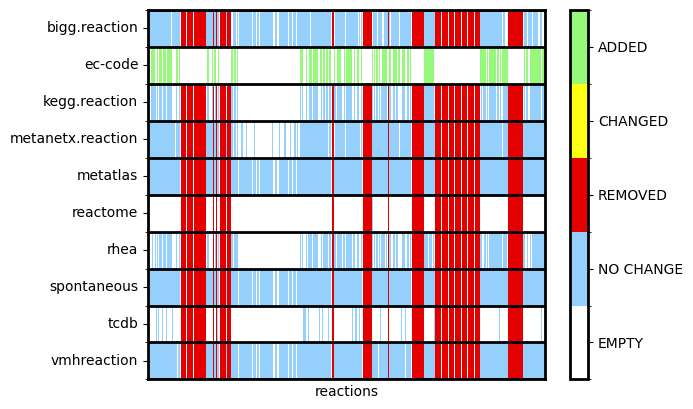

In [9]:
df_model = get_annotation_df(
    getattr(model, annotation_type), 
    [annotation_key]
).rename({"id": annotation_type}, axis=1)

df_annotations = get_annotations_HumanGEM(annotation_type, database_dirpath)
df_annotations = df_annotations.rename({"rxns": "rxnMetAtlas"}, axis=1)
df_annotations = df_annotations.merge(
    pd.DataFrame.from_dict({
        rxn.id: build_string(rxn.annotation.get("ec-code", []))
        for rxn in HumanGEM.reactions if rxn.annotation.get("ec-code", [])
    }, orient="index", columns=["ec-code"]),
    left_on="rxnMetAtlas",
    right_index=True,
    how="left"
)

df_annotations = df_model.merge(
    df_annotations,
    left_on=annotation_key,
    right_on=merge_key if merge_key is not None else annotation_key,
    how="left"
)

if merge_key is not None and merge_key != annotation_key:
    df_annotations = df_annotations.drop(annotation_key, axis=1)

df_annotations = df_annotations.loc[:, [annotation_type] + annotation_columns]
if rename_miriam:
    df_annotations = df_annotations.rename(
        HUMANGEM_MIRIAM[annotation_type], 
        axis=1
    )
    # Clean up Rhea if MIRIAM formats are being applied
    if "rhea" in df_annotations.columns:
        df_annotations["rhea"] = df_annotations["rhea"].str.lstrip("RHEA:")

if compare:
    try:
        df_previous = pd.read_csv(
            f"{annotation_dirpath}/{annotation_type}_{database_tag}.tsv", 
            sep="\t", 
            index_col=0,
            dtype=str,
        )
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=[annotation_type], dtype=str)

    df_comparision = compare_tables(
        df_previous.set_index(annotation_type),
        df_annotations.set_index(annotation_type)
    )
    ax = visualize_comparison(df_comparision)


if overwrite:
    df_annotations.to_csv(f"{annotation_dirpath}/{annotation_type}_{database_tag}.tsv", sep="\t")
else:
    df_annotations.to_csv(f"{ROOT_PATH}{INTERIM_PATH}/{annotation_type}_{database_tag}.tsv", sep="\t")
df_annotations

## Metabolites

* `metabolites_Human-GEM.tsv` content:

|# |fieldname      |annotation                             |Prefixes (https://identifiers.org/)|
|--|---------------|---------------------------------------|-----------------------------------|
|1 |mets           |identical to `model.mets`              |metatlas                           |
|2 |metsNoComp     |`model.mets` without compartment suffix|                                   |
|3 |metBiGGID      |BiGG metabolite ID                     |bigg.metabolite                    |
|4 |metKEGGID      |KEGG metabolite ID                     |kegg.compound                      |
|5 |metHMDBID      |HMDB ID                                |hmdb                               |
|6 |metChEBIID     |ChEBI ID                               |chebi                              |
|7 |metPubChemID   |PubChem ID                             |pubchem.compound                   |
|8 |metLipidMapsID |LipidMaps ID                           |lipidmaps                          |
|9 |metEHMNID      |EHMN metabolite ID                     |                                   |
|10|metHepatoNET1ID|HepatoNET1 metabolite ID               |                                   |
|11|metRecon3DID   |Recon3D metabolite ID                  |vmhmetabolite                      |
|12|metMetaNetXID  |MetaNetX metabolite ID                 |metanetx.chemical                  |
|13|metHMR2ID      |HMR2 metabolite ID                     |                                   |
|14|metRetired     |Retired metabolite IDs                 |                                   |

##### Notes

* Include columns that link to https://identifiers.org/.

In [10]:
annotation_type = "metabolites"
annotation_key = "metatlas"
merge_key = "metMetAtlas"
rename_miriam = True

annotation_columns = HUMANGEM_MIRIAM[annotation_type].copy()
annotation_columns = list(annotation_columns)

,metabolites,metatlas,bigg.metabolite,kegg.compound,hmdb,chebi,pubchem.compound,lipidmaps,vmhmetabolite,metanetx.chemical
0,13dpg_c,MAM00247c,13dpg,C00236,NaN,CHEBI:16001,439191,NaN,13dpg,MNXM261
1,23dpg_c,MAM00569c,23dpg,C01159,NaN,CHEBI:17720,NaN,NaN,23dpg,MNXM146487;MNXM892
2,2kmb_c,MAM01016c,2kmb,C01180,NaN,CHEBI:33574,NaN,LMFA01060170,2kmb,MNXM276
3,2pg_c,MAM00674c,2pg,C00631,NaN,CHEBI:17835,439278,NaN,2pg,MNXM275
4,35camp_c,MAM01419c,camp,C00575,HMDB0000058,CHEBI:17489,6076,NaN,camp,MNXM243
...,...,...,...,...,...,...,...,...,...,...
287,xmp_c,MAM03150c,xmp,C00655,NaN,CHEBI:15652,73323,NaN,xmp,MNXM298
288,xu5p__D_c,MAM01761c,xu5p__D,C00231,NaN,CHEBI:16332,439190,NaN,xu5p_D,MNXM186
289,xylt_c,MAM03155c,xylt,C00379,HMDB0002917,CHEBI:1305691,6912,NaN,xylt,MNXM510
290,xylu__D_c,MAM01759c,xylu__D,C00310,HMDB0001644,CHEBI:17140,5289590,NaN,xylu_D,MNXM597


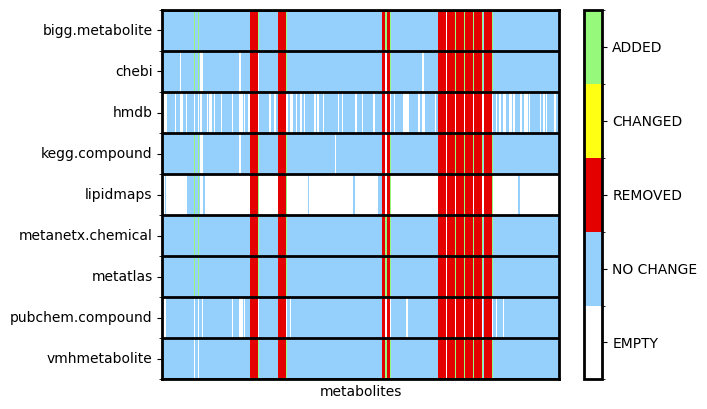

In [11]:
df_model = get_annotation_df(
    getattr(model, annotation_type), 
    [annotation_key]
).rename({"id": annotation_type}, axis=1)

df_annotations = get_annotations_HumanGEM(annotation_type, database_dirpath)
df_annotations = df_annotations.rename({"mets": "metMetAtlas"}, axis=1)
df_annotations = df_model.merge(
    df_annotations,
    left_on=annotation_key,
    right_on=merge_key if merge_key is not None else annotation_key,
    how="left"
)
if merge_key is not None and merge_key != annotation_key:
    df_annotations = df_annotations.drop(annotation_key, axis=1)

df_annotations = df_annotations.loc[:, [annotation_type] + annotation_columns]
if rename_miriam:
    df_annotations = df_annotations.rename(
        HUMANGEM_MIRIAM[annotation_type], 
        axis=1
    )

if compare:
    try:
        df_previous = pd.read_csv(
            f"{annotation_dirpath}/{annotation_type}_{database_tag}.tsv",
            sep="\t",
            index_col=0,
            dtype=str,
        )
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=[annotation_type], dtype=str)

    df_comparision = compare_tables(
        df_previous.set_index(annotation_type),
        df_annotations.set_index(annotation_type)
    )
    ax = visualize_comparison(df_comparision)
if overwrite:
    df_annotations.to_csv(f"{annotation_dirpath}/{annotation_type}_{database_tag}.tsv", sep="\t")
else:
    df_annotations.to_csv(f"{ROOT_PATH}{INTERIM_PATH}/{annotation_type}_{database_tag}.tsv", sep="\t")
df_annotations

## Genes

* `genes_Human-GEM.tsv` content:

|# |fieldname     |  annotation          |Prefixes (https://identifiers.org/)|
|--|--------------|----------------------|-----------------------------------|
|1 |genes         |Ensembl gene ID       |ensembl                            |
|2 |geneENSTID    |Ensembl transcript ID |ensembl                            |
|3 |geneENSPID    |Ensembl protein ID    |ensembl                            |
|4 |geneUniProtID |UniProt ID            |uniprot                            |
|5 |geneSymbols   |Gene Symbol           |hgnc.symbol                        |
|6 |geneEntrezID  |NCBI Entrez ID        |ncbigene                           |
|7 |geneNames     |Gene Name             |                                   |
|8 |geneAliases   |Alias Names           |                                   |
|9 |compartments  |Subcellular location  |                                   |
|10|compDataSource|Source for compartment|                                   |


##### Notes
* Unlike `reactions` and `metabolites`, the Human-GEM reconstruction does not have its own unique identifiers for genes but instead uses the 'Ensembl gene ID'. Therefore, slight alterations to the code are made to account for differences. 
* It is recommended to unify model with annotations using the NCBI Entrez ID or the UniProt ID.
* Include columns that link to https://identifiers.org/.
* For `ensembl`, the Ensembl gene ID is utilized for the annotation.

In [12]:
annotation_type = "genes"
annotation_key = "uniprot"
merge_key = "geneUniProtID"
rename_miriam = True
annotation_columns = HUMANGEM_MIRIAM[annotation_type].copy()
# Two mappings, only keep ensemble genes
del annotation_columns["geneENSTID"]
del annotation_columns["geneENSPID"]
annotation_columns = list(annotation_columns)

,genes,ensembl,uniprot,hgnc.symbol,ncbigene
0,ABCC4,ENSG00000125257,O15439,ABCC4,10257
1,ABCG2,ENSG00000118777,Q9UNQ0,ABCG2,9429
2,ACP1,NaN,NaN,NaN,NaN
3,ACSL1,ENSG00000151726,P33121,ACSL1,2180
4,ADA,ENSG00000196839,P00813,ADA,100
...,...,...,...,...,...
278,UMPS,ENSG00000114491,P11172,UMPS,7372
279,UROD,ENSG00000126088,P06132,UROD,7389
280,UROS,ENSG00000188690,P10746,UROS,7390
281,XYLB,ENSG00000093217,O75191,XYLB,9942


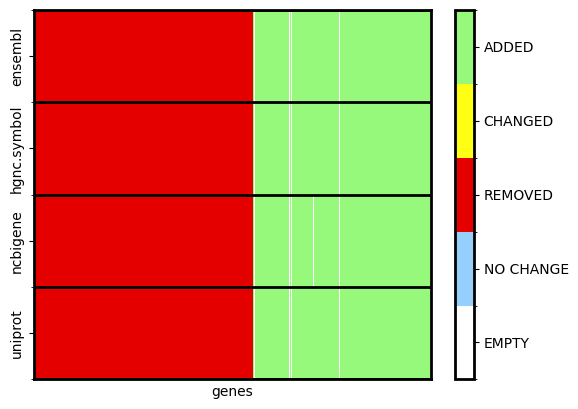

In [13]:
df_model = get_annotation_df(
    getattr(model, annotation_type), 
    [annotation_key]
).rename({"id": annotation_type}, axis=1)

df_annotations = get_annotations_HumanGEM(annotation_type, database_dirpath)
df_annotations = df_annotations.rename({"genes": "geneEnsemblID"}, axis=1)
df_annotations = df_model.merge(
    df_annotations,
    left_on=annotation_key,
    right_on=merge_key if merge_key is not None else annotation_key,
    how="left"
)
if merge_key is not None and merge_key != annotation_key:
    df_annotations = df_annotations.drop(annotation_key, axis=1)

df_annotations = df_annotations.loc[:, [annotation_type] + annotation_columns]

if rename_miriam:
    df_annotations = df_annotations.rename(
        HUMANGEM_MIRIAM[annotation_type], 
        axis=1
    )

if compare:
    try:
        df_previous = pd.read_csv(
            f"{annotation_dirpath}/{annotation_type}_{database_tag}.tsv",
            sep="\t",
            index_col=0,
            dtype=str,
        )
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=[annotation_type], dtype=str)

    df_comparision = compare_tables(
        df_previous.set_index(annotation_type),
        df_annotations.set_index(annotation_type)
    )
    ax = visualize_comparison(df_comparision)
if overwrite:
    df_annotations.to_csv(f"{annotation_dirpath}/{annotation_type}_{database_tag}.tsv", sep="\t")
else:
    df_annotations.to_csv(f"{ROOT_PATH}{INTERIM_PATH}/{annotation_type}_{database_tag}.tsv", sep="\t")
df_annotations